In [1]:
from IPython.display import display, HTML
import itertools
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from time import perf_counter
from tqdm.notebook import tqdm

In [2]:
cd ../

/home/guillaume/recimpute


In [3]:
%load_ext autoreload
%autoreload 2
from Clustering.ShapeBasedClustering import ShapeBasedClustering
from Datasets.Dataset import Dataset
from Labeling.ImputationTechniques.ImputeBenchLabeler import ImputeBenchLabeler

In [ ]:
if not os.path.exists('Experiments/results'):
    os.makedirs('Experiments/results')

## Generate pipelines

In [4]:
class Pipeline():
    def __init__(self, method_name, params_dict, main_param_key):
        self.method_name = method_name
        self.params_dict = params_dict
        self.main_param_key = main_param_key
    def get_algx(self):
        return '-algx', self.method_name, str(self.params_dict[self.main_param_key])
    def get_alg(self):
        return '-alg', self.method_name
    def get_id(self):
        return '%s_%s' % (
            pipeline.method_name, 
            '_'.join('%s_%s' % (k.replace(' ', ''),str(v)) for k,v in pipeline.params_dict.items())
        )
    def __str__(self):
        return '%s: %s' % (self.method_name, str(self.params_dict))

In [5]:
PIPELINES = [
    
    Pipeline('cdrec', {'reduction': 4}, 'reduction'),
    # Pipeline('cdrec', {'reduction': 5}, 'reduction'),
    
    Pipeline('grouse', {'reduction': 1}, 'reduction'),
    # Pipeline('grouse', {'reduction': 2}, 'reduction'),
    
    Pipeline('rosl', {'reduction': 1}, 'reduction'),
    # Pipeline('rosl', {'reduction': 2}, 'reduction'),
    
    Pipeline('softimp', {'reduction': 1}, 'reduction'),
    # Pipeline('softimp', {'reduction': 2}, 'reduction'),
    
    #Pipeline('spirit', {'reduction': 1}, 'reduction'),
    # Pipeline('spirit', {'reduction': 2}, 'reduction'),
    
    Pipeline('svdimp', {'reduction': 1}, 'reduction'),
    # Pipeline('svdimp', {'reduction': 5}, 'reduction'),
    
    Pipeline('tenmf', {'reduction': 1}, 'reduction'),
    # Pipeline('tenmf', {'reduction': 5}, 'reduction'),
    
    Pipeline('stmvl', {'decay rate': 1}, 'decay rate'),
    # Pipeline('stmvl', {'decay rate': 5}, 'decay rate'),
    
]

## Load the data sets

In [6]:
clusterer = ShapeBasedClustering()
ALL_DATASETS = Dataset.instantiate_from_dir(clusterer)
IBL = ImputeBenchLabeler.get_instance()

In [7]:
def get_filenames(mode):
    results_filename = 'Experiments/results/autoaits_results_%i.csv' % mode
    bench_results_filename = 'Experiments/results/autoaits_benchresults_%i.csv' % mode
    return results_filename, bench_results_filename

## Set parameters
do not change if you want to obtain the results as in the paper

In [8]:
DATA_USAGE_PERCENTAGES = [5, 10, 17, 30]

# 0: select X % of complete time series                (nb time series varies, sequences' length is always the same)
# 1: for each time series, select X % of their length  (nb time series is always the same, sequences' length varies)
DATA_USAGE_STRAT = 0

# 'eval': uses all pipelines with 100% of the data to verify the predictions
# 'use': only uses the top-N pipelines with 100% of the data
MODE = 'eval'

# number of pipelines to use on all data if in mode 'use'
N = 3

USE_DEFAULT_PARAMS = True

NB_DATASETS = 40

results_filename, bench_results_filename = get_filenames(DATA_USAGE_STRAT)

## T-Daub on each data set

In [9]:
def filter_datasets(dataset, DATA_USAGE_PERCENTAGES, DATA_USAGE_STRAT):
    cond1 = math.floor(dataset.nb_timeseries * (min(DATA_USAGE_PERCENTAGES) / 100)) >= 5
    cond2 = math.floor(dataset.timeseries_length * (min(DATA_USAGE_PERCENTAGES) / 100)) >= 100
    return cond1 if DATA_USAGE_STRAT == 0 else (cond2 if DATA_USAGE_STRAT == 1 else None)

ALL_DATASETS_FILTERED = list(filter(lambda ds: filter_datasets(ds, DATA_USAGE_PERCENTAGES, DATA_USAGE_STRAT), ALL_DATASETS))
DATASETS = np.random.choice(ALL_DATASETS_FILTERED, NB_DATASETS, replace=False)

In [10]:
def generate_results_dataframes(DATASETS, PIPELINES, DATA_USAGE_PERCENTAGES):
    my_index = pd.MultiIndex.from_tuples(
        list(itertools.product([ds.name for ds in DATASETS], [str(pipe) for pipe in PIPELINES])), 
        names=['DATA SET', 'PIPELINE']
    )
    my_columns = pd.MultiIndex.from_tuples(
        list(itertools.product(DATA_USAGE_PERCENTAGES, ['Error', 'Runtime'])),
        names=['DATA USAGE %', '-']
    )
    results = pd.DataFrame(index=my_index, columns=my_columns)
    results[[(100, 'Expected Error')]] = np.nan
    results[[(100, 'Error')]] = np.nan
    results[[(100, 'Runtime')]] = np.nan
    results.head(3)
    
    my_columns2 = pd.MultiIndex.from_tuples(
        list(itertools.product(DATA_USAGE_PERCENTAGES + [100], ['Benchmark Results'])),
        names=['DATA USAGE %', '-']
    )
    results2 = pd.DataFrame(index=my_index, columns=my_columns2)
    results2
    
    return results, results2

In [89]:
results, bench_results = generate_results_dataframes(DATASETS, PIPELINES, DATA_USAGE_PERCENTAGES)
results.head(3)

DATA USAGE %                        5             10            17           \
-                                 Error Runtime Error Runtime Error Runtime   
DATA SET PIPELINE                                                             
FaceAll  cdrec: {'reduction': 4}    NaN     NaN   NaN     NaN   NaN     NaN   
         grouse: {'reduction': 1}   NaN     NaN   NaN     NaN   NaN     NaN   
         rosl: {'reduction': 1}     NaN     NaN   NaN     NaN   NaN     NaN   

DATA USAGE %                        30                     100                
-                                 Error Runtime Expected Error Error Runtime  
DATA SET PIPELINE                                                             
FaceAll  cdrec: {'reduction': 4}    NaN     NaN            NaN   NaN     NaN  
         grouse: {'reduction': 1}   NaN     NaN            NaN   NaN     NaN  
         rosl: {'reduction': 1}     NaN     NaN            NaN   NaN     NaN

In [90]:
bench_results.head(3)

DATA USAGE %                                    5                 10   \
-                                 Benchmark Results Benchmark Results   
DATA SET PIPELINE                                                       
FaceAll  cdrec: {'reduction': 4}                NaN               NaN   
         grouse: {'reduction': 1}               NaN               NaN   
         rosl: {'reduction': 1}                 NaN               NaN   

DATA USAGE %                                    17                30   \
-                                 Benchmark Results Benchmark Results   
DATA SET PIPELINE                                                       
FaceAll  cdrec: {'reduction': 4}                NaN               NaN   
         grouse: {'reduction': 1}               NaN               NaN   
         rosl: {'reduction': 1}                 NaN               NaN   

DATA USAGE %                                    100  
-                                 Benchmark Results  
DATA SET PIPELINE                                    
FaceAll  cdrec: {'reduction': 4}                NaN  
         grouse: {'reduction': 1}               NaN  
         rosl: {'reduction': 1}                 NaN

In [ ]:
# RUN t-daub
for ds in tqdm(DATASETS, leave=True, total=len(DATASETS)):
    timeseries = ds.load_timeseries(transpose=False) # each column is a time series
    timeseries_length = timeseries.shape[0]
    nb_timeseries = timeseries.shape[1]
    assert timeseries_length == ds.timeseries_length and nb_timeseries == ds.nb_timeseries
    
    #print(ds.name, nb_timeseries, timeseries_length) # TODO tmp
    
    # randomly shuffle the time series
    timeseries = timeseries.sample(frac=1, axis=1, random_state=23)
    timeseries.columns = range(len(timeseries.columns))
    
    for data_usage_perc in tqdm(sorted(DATA_USAGE_PERCENTAGES), leave=False, total=len(DATA_USAGE_PERCENTAGES)):
        # select the time series to use
        if DATA_USAGE_STRAT == 0: # select X % of complete time series
            nb_timeseries_to_use = math.floor(nb_timeseries * (data_usage_perc / 100))
            assert nb_timeseries_to_use >= 5
            timeseries_subset = timeseries[range(nb_timeseries_to_use)]
        elif DATA_USAGE_STRAT == 1: # for each time series, select X % of their length
            length_to_use = math.floor(timeseries_length * (data_usage_perc / 100))
            assert length_to_use >= 100
            timeseries_subset = timeseries.iloc[:length_to_use]
        else: raise Exception('Unknown data usage strategy.')

        #print('subset:', timeseries_subset.shape[1], timeseries_subset.shape[0], '%i%%' % data_usage_perc) # TODO tmp
            
        # run each pipeline on this subset
        for pipeline in tqdm(PIPELINES, leave=False, total=len(PIPELINES)):
            #print('\n\n%s' % pipeline) # TODO tmp
            start_time = perf_counter()
            bench_res, _ = IBL._run_benchmark(
                timeseries_subset, 
                alg_algx_cmd= pipeline.get_alg() if USE_DEFAULT_PARAMS else pipeline.get_algx(),
                scenario='miss_perc',
                errors=['mae', 'mse', 'rmse'],
                id='%s_%i__%s' % (
                    ds.name, 
                    data_usage_perc, 
                    pipeline.get_id()),
                plots=False, 
                delete_results=True
            )
            runtime = perf_counter() - start_time
            
            # retrieve the lowest error from the benchmark
            ranking_strat_params = ImputeBenchLabeler.CONF['BENCH_RES_AGG_AND_RANK_STRATEGY_PARAMS']['simple']
            agg_bench_res = IBL._aggregate_bench_res(bench_res, 
                                                     index_to_agg=ranking_strat_params['index_to_agg'], 
                                                     agg_strat=ranking_strat_params['agg_strat'])
            _, error = IBL._get_highest_bench_score(agg_bench_res, 'rmse', algos_to_exclude=[])
            
            results.at[(ds.name, str(pipeline)), (data_usage_perc, 'Runtime')] = runtime
            results.at[(ds.name, str(pipeline)), (data_usage_perc, 'Error')] = error
            bench_results.at[(ds.name, str(pipeline)), (data_usage_perc, 'Benchmark Results')] = bench_res.to_dict()
            
            #print(results.loc[(ds.name, str(pipeline)), (data_usage_perc, slice(None))]) # TODO tmp
            
            results.to_csv(results_filename)
            bench_results.to_csv(bench_results_filename)
results.head(3)

## Predict which pipelines should work the best and use them on all data

In [96]:
# for each data set:
#   for each pipeline:
#     use a regression model to predict the lowest error at 100%
#   rank the pipelines according to the 100, Lowest error column
#   select the top-N pipelines
#   train the top-N pipelines on 100% of the data

In [ ]:
# identify and use the expected best-performing methods
for ds in tqdm(DATASETS, leave=True, total=len(DATASETS)):
    timeseries = ds.load_timeseries(transpose=False) # each column is a time series
    timeseries_length = timeseries.shape[0]
    nb_timeseries = timeseries.shape[1]
    assert timeseries_length == ds.timeseries_length and nb_timeseries == ds.nb_timeseries
    
    #print(ds.name, nb_timeseries, timeseries_length) # TODO tmp
    
    # predict which pipelines will perform the best with 100% of the data
    for pipeline in tqdm(PIPELINES, leave=False, total=len(PIPELINES)):
        errors = np.array(results.loc[(ds.name, str(pipeline)), (results.columns.get_level_values(0) != 100, 'Error')]\
                                        .tolist())\
                                        .reshape(-1, 1)
        # linear regression
        reg = LinearRegression().fit(np.array(DATA_USAGE_PERCENTAGES).reshape(-1, 1), errors)

        # ranking of the pipelines based on their predicted scores when using all data
        results.at[(ds.name, str(pipeline)), (100, 'Expected Error')] = reg.predict([[100]])[0][0]
    
    best_pipelines = results.loc[ds.name, :]\
                            .sort_values(by=(100, 'Expected Error'), ascending=False)\
                            .iloc[0:N].index.tolist()
    
    # use the best pipelines on all data
    pipelines_to_use = None
    if MODE == 'eval':
        pipelines_to_use = PIPELINES
    elif MODE == 'use':
        pipelines_to_use = best_pipelines
    else: raise Exception('Unknown mode')
    
    for pipeline in tqdm(pipelines_to_use, leave=False, total=len(pipelines_to_use)):
        #print('\n\n%s' % pipeline) # TODO tmp
        start_time = perf_counter()
        bench_res, _ = IBL._run_benchmark(
            timeseries, 
            alg_algx_cmd= pipeline.get_alg() if USE_DEFAULT_PARAMS else pipeline.get_algx(),
            scenario='miss_perc',
            errors=['mae', 'mse', 'rmse'],
            id='%s_%i__%s' % (
                    ds.name, 
                    data_usage_perc, 
                    pipeline.get_id()),
            plots=False, 
            delete_results=True
        )
        runtime = perf_counter() - start_time
        
        # retrieve the lowest error from the benchmark
        ranking_strat_params = ImputeBenchLabeler.CONF['BENCH_RES_AGG_AND_RANK_STRATEGY_PARAMS']['simple']
        agg_bench_res = IBL._aggregate_bench_res(bench_res, 
                                                 index_to_agg=ranking_strat_params['index_to_agg'], 
                                                 agg_strat=ranking_strat_params['agg_strat'])
        _, error = IBL._get_highest_bench_score(agg_bench_res, 'rmse', algos_to_exclude=[])
            
        results.at[(ds.name, str(pipeline)), (100, 'Runtime')] = runtime
        results.at[(ds.name, str(pipeline)), (100, 'Error')] = error
        bench_results.at[(ds.name, str(pipeline)), (100, 'Benchmark Results')] = bench_res.to_dict()
        
        #print(results.loc[(ds.name, str(pipeline)), (100, slice(None))]) # TODO tmp

        results.to_csv(results_filename)
        bench_results.to_csv(bench_results_filename)

In [120]:
results.dropna(axis=0).to_csv(results_filename)
bench_results.dropna(axis=0).to_csv(bench_results_filename)

# Plots

In [121]:
def load_results_file(filename):
    results = pd.read_csv(filename, 
                          index_col=[0,1], header=[0,1], skipinitialspace=True)
    results.columns = results.columns.set_levels(
          results.columns.levels[0].astype('int64'), level=0
    )
    return results

In [122]:
def plot_from_results(subject, results, pipelines, argx, title, plot=True):
    sns.set_theme()
    sns.set_style('darkgrid')
    results_ = results.astype('float32')
    
    if isinstance(results_.index, pd.MultiIndex):
        all_ys = results_.groupby('PIPELINE').mean()
    else:
        all_ys = results_
    colors = cm.gist_rainbow(np.linspace(0, 1, len(pipelines)))
    for pipeline, c in zip(pipelines, colors):
        x = sorted(results_.columns.levels[0].tolist())
        y = all_ys.loc[str(pipeline), (slice(None), subject)].tolist()
        plt.plot(x, y, color=c, label= str(pipeline) if argx else pipeline.method_name)
    plt.xlabel('Data usage %')
    plt.xticks(x)
    plt.ylabel(subject)
    #max_y = all_ys.loc[slice(None), (slice(None), subject)].quantile(.75).max()
    #print(max_y, all_ys.loc[slice(None), (slice(None), subject)].max().max())
    plt.ylim([0, min(180, all_ys.loc[slice(None), (slice(None), subject)].max().max())])
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
    plt.rcParams['figure.figsize'] = (8,6)
    if plot:
        plt.show()
    return colors

In [170]:
def all_plots_and_prints(results, per_dataset=False):
    # average over all data sets
    print('============================================================\n', '\033[1m Average over all data sets: \033[0m')
    _ = plot_from_results('Runtime', results, PIPELINES, 
                          argx=False, title='Average runtime in seconds over all data sets')
    
    colors = plot_from_results('Error', results, PIPELINES, 
                               argx=False, title='Average RMSE error (and predicted error) over all data sets', plot=False)
    #x, y = [], []
    #all_ys = results.groupby('PIPELINE').mean()
    #for pipeline in PIPELINES:
    #    x.append(100)
    #    y.extend(all_ys.loc[str(pipeline), (slice(None), 'Expected Error')].tolist())
    #plt.scatter(x, y, color=colors)
    #plt.show()
    
    # per data set
    if per_dataset:
        print('============================================================\n', '\033[1m Per data set: \033[0m')
        metrics = {'prec@3': [], 'rec@3': [], 'mrr': []}
        y_true, y_pred = [], []
        for ds_name in results.index.levels[0].tolist():

            print('\n\n', '\033[1m', ds_name, '\033[0m')

            results_subset = results.copy(deep=True).loc[(ds_name, slice(None))]

            # plot errors & predicted error
            #colors = plot_from_results('Error', results_subset, PIPELINES, 
            #                           argx=False, title='RMSE error (and predicted error) for data set %s' % ds_name, plot=False)
            #x, y = [], []
            #if isinstance(results_subset.index, pd.MultiIndex):
            #    all_ys = results_subset.groupby('PIPELINE').mean()
            #else:
            #    all_ys = results_subset
            #for pipeline in PIPELINES:
            #    x.append(100)
            #    y.extend(all_ys.loc[str(pipeline), (slice(None), 'Expected Error')].tolist())
            #plt.scatter(x, y, color=colors)
            #plt.show()

            # ranking comparison
            df = pd.DataFrame(zip(results_subset.sort_values((100, 'Expected Error')).index.tolist(), 
                                  results_subset.sort_values((100, 'Error')).index.tolist()))
            #df = df.applymap(lambda s: s.method_name)
            df.columns = ['Expected Error', 'Error']
            df.index.name = 'Ranking'
            df.index = range(1, df.shape[0]+1)
            #display(df)

            # evaluate
            nb_correct_labels = 1
            correct_labels = df['Error'].iloc[:nb_correct_labels].tolist()
            correct_labels_rank = [df[df['Expected Error'] == corr_lbl].index.tolist().pop() for corr_lbl in correct_labels] # rank at which each correct label is found

            y_true.append(df['Error'].iloc[0])
            y_pred.append(df['Expected Error'].iloc[0])

            K = 3
            prec_at_K = sum(int(rank_i <= K) for rank_i in correct_labels_rank) / K
            rec_at_K = sum(int(rank_i <= K) for rank_i in correct_labels_rank) / len(correct_labels)
            mrr = 1 / correct_labels_rank[0]
            metrics['prec@3'].append(prec_at_K)
            metrics['rec@3'].append(rec_at_K)
            metrics['mrr'].append(mrr)
            #print('Precision@3: %.2f | Recall@3: %.2f' % (prec_at_K, rec_at_K))
        
    print('\n\n============================================================\n', '\033[1m Average metrics: \033[0m')
    
    acc = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
    prec = precision_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0).tolist()
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0).tolist()
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)
    
    avg_prec3 = sum(metrics['prec@3']) / len(metrics['prec@3'])
    avg_rec3 = sum(metrics['rec@3']) / len(metrics['rec@3'])
    mrr = (1 / len(metrics['mrr'])) * sum(metrics['mrr'])
    print('Average precision@3: %.2f | Average recall@3: %.2f | Mean reciprocal rank: %.2f' % (avg_prec3, avg_rec3, mrr))
    print('Accuracy: %.2f | Precision: %.2f | Recall: %.2f | F1-Score: %.2f' % (acc, prec, recall, f1))
    
    return y_true, y_pred

  Average over all data sets: 


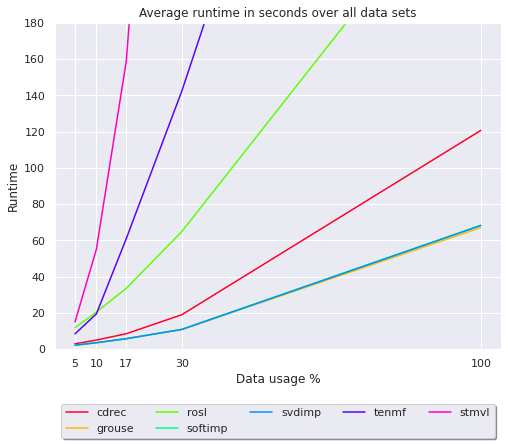

  Per data set: 


  Average metrics: 
Average precision@3: 0.13 | Average recall@3: 0.38 | Mean reciprocal rank: 0.37
Accuracy: 0.18 | Precision: 0.42 | Recall: 0.18 | F1-Score: 0.18


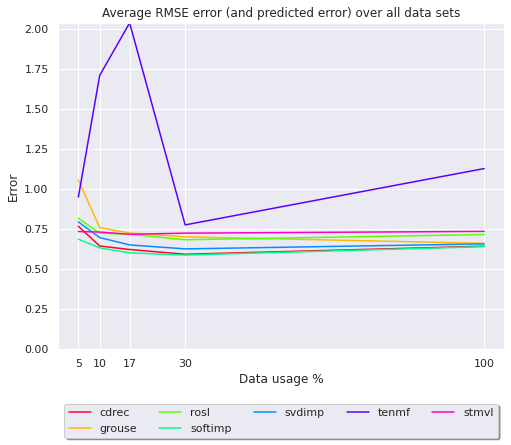

In [171]:
results = load_results_file(get_filenames(0)[0])
#display(results)
y_true0, y_pred0 = all_plots_and_prints(results)

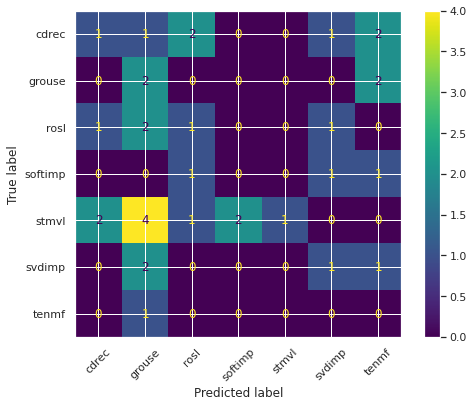

In [173]:
y_pred0_ = list(map(lambda s: s.split(':')[0], y_pred0))
y_true0_ = list(map(lambda s: s.split(':')[0], y_true0))
ConfusionMatrixDisplay.from_predictions(y_true=y_true0_, y_pred=y_pred0_, xticks_rotation=45)